In [3]:
%cd ../../data

c:\Users\wine\Giang\Code\Python\QGNN_Comm\data


c:\Users\wine\anaconda3\envs\QGNN\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
import numpy as np
import torch
from torch_geometric.loader import  DataLoader
from torch_geometric.data import HeteroData, Data, Dataset, Batch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, ELU, Sigmoid, BatchNorm1d as BN, ReLU6 as ReLU6, PReLU, SiLU
import scipy.io
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

## Create Dataset

In [5]:
def normalize_data(train_data,test_data):
    train_mean = np.mean(train_data)
    train_std = np.std(train_data)
    norm_train = (train_data)/train_std
    norm_test = (test_data)/train_std
    n1, n2 = norm_train.shape[0], norm_test.shape[0]
    return norm_train, norm_test

In [6]:
class PCDataset(Dataset):
    ## norm_losses: normalized beta - large-scale variance
    ## direct: direct term - for rate calculation only
    ## cross: interference term - for rate calculation only
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype=torch.float)
        self.cross = torch.tensor(cross, dtype=torch.float)
        self.KM = KM
        self.get_cg()
        self.process()

    def build_graph(self, idx):
        edge_feature = self.norm_losses[idx, :, :].reshape((self.KM[0] * self.KM[1], 1), order='F')
        # x = self.direct[idx, :, :].reshape((self.KM[0] * self.KM[1], 1), order='F')
        edge_feature = np.concatenate((edge_feature,  np.ones_like(edge_feature)), axis=-1)
        edge_feature = torch.tensor(edge_feature, dtype=torch.float)

        edge_index = torch.tensor(self.adj, dtype=torch.long).t().contiguous()
        edge_index_t = torch.tensor(self.adj_t, dtype=torch.long).t().contiguous()
        ue_features = torch.ones((self.KM[0], 1)) #K
        ap_features = torch.ones((self.KM[1], 1)) #M

        edge_sum_ue = torch.sum(edge_feature.reshape(self.KM[0], self.KM[1], 2), axis=1)
        edge_sum_ap = torch.sum(edge_feature.reshape(self.KM[0], self.KM[1], 2), axis=0).reshape(self.KM[1], 2)

        data = HeteroData()
        data['UE'].x = ue_features
        data['AP'].x = ap_features
        data['UE', 'com-by', 'AP'].edge_index = edge_index
        data['UE', 'com-by', 'AP'].edge_attr = edge_feature
        data['AP', 'com', 'UE'].edge_index = edge_index_t
        data['AP', 'com', 'UE'].edge_attr = edge_feature
        data['UE'].edge_sum = edge_sum_ue
        data['AP'].edge_sum = edge_sum_ap
        return data

    def get_cg(self):
        self.adj = []
        self.adj_t = []
        for i in range(self.KM[0]):
            for j in range(self.KM[1]):
                self.adj.append([i, j])
                self.adj_t.append([j, i])

    def process(self):
        self.graph_list = [self.build_graph(i) for i in range(len(self.direct))]

    def __len__(self):
        return len(self.direct)

    def __getitem__(self, index):
        return self.graph_list[index], self.direct[index], self.cross[index]

In [7]:
def collate(samples):
    '''Pytorch Geometric collate function'''
    graphs, direct, cross = map(list, zip(*samples))
    batched_graph = Batch.from_data_list(graphs)
    return batched_graph, torch.stack(direct), torch.stack(cross)

## Build Graph Neural Networks

In [8]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])
class EdgeConv(MessagePassing):
    def __init__(self, input_dim, node_dim, **kwargs):
        super(EdgeConv, self).__init__(aggr='mean')  # mean aggregation
        self.lin = MLP([input_dim, 32])
        self.res_lin = Lin(node_dim, 32)
        self.bn = BN(32)

    def forward(self, x, edge_index, edge_attr):

        feat_src, feat_dst = x


        out = self.propagate(edge_index=edge_index, x=(feat_src, feat_dst), edge_attr=edge_attr)


        return self.bn(out + self.res_lin(feat_dst))

    def message(self, x_j, x_i, edge_attr):
        # Tạo ra thông điệp từ các nút nguồn, nút đích và đặc tính cạnh
        out = torch.cat([x_j, x_i, edge_attr], dim=1)
        return self.lin(out)

    def update(self, aggr_out):
        # Cập nhật giá trị nút đích sau khi tập hợp
        return aggr_out



In [9]:
class RGCN(nn.Module):
    def __init__(self):
        super(RGCN, self).__init__()
        self.conv1 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(4, 1),
            ('AP', 'com', 'UE'): EdgeConv(4, 1)
        }, aggr='mean')

        self.conv2 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='mean')

        self.conv3 = HeteroConv({
            ('UE', 'com-by', 'AP'): EdgeConv(66, 32),
            ('AP', 'com', 'UE'): EdgeConv(66, 32)
        }, aggr='mean')

        self.mlp = MLP([32, 16])
        self.mlp = nn.Sequential(*[self.mlp, Seq(Lin(16, 1), Sigmoid())])

    def forward(self,x_dict, edge_index_dict, edge_attr_dict):
        out = self.conv1(x_dict, edge_index_dict, edge_attr_dict)
        out = self.conv2(out, edge_index_dict, edge_attr_dict)
        out = self.conv3(out, edge_index_dict, edge_attr_dict)
        out = self.mlp(out['UE'])
        return out


## Function

In [10]:
def rate_loss(allocs, directlink_channel_losses, crosslink_channel_losses, test_mode = False):
    SINRs_numerators = allocs * directlink_channel_losses**2
    SINRs_denominators = torch.squeeze(torch.matmul(crosslink_channel_losses, torch.unsqueeze(allocs, axis=-1))) + directlink_channel_losses
    SINRs = SINRs_numerators / SINRs_denominators
    rates = torch.log2(1 + SINRs)
    min_rate = torch.min(rates, dim = 1)[0] # take min
    if test_mode:
        return min_rate
    else:
        return -torch.mean(min_rate)

In [11]:
def train_model(epoch, model, optimizer, train_loader):
    """ Train for one epoch. """
    model.train()
    loss_all = 0
    for batch_idx, (data, d_train, c_train) in enumerate(train_loader):
        K = d_train.shape[-1]
        n = len(data['UE'].x)
        bs = len(data['UE'].x) // K

        optimizer.zero_grad()

        # Lấy các đặc trưng nút từ từ điển x_dict
        user_feats = data['AP'].x
        item_feats = data['UE'].x
        node_features = {'AP': user_feats, 'UE': item_feats}

        # Truyền qua mô hình, bao gồm cả edge_attr_dict
        output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)
        # Tính loss và thực hiện backpropagation
        loss = rate_loss(output, d_train, c_train)
        loss.backward()

        loss_all += loss.item() * bs
        optimizer.step()

    return loss_all / len(train_loader.dataset)

def test_model(loader, model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (data, d_test, c_test) in loader:
            K = d_test.shape[-1]
            n = len(data['UE'].x)
            bs = len(data['UE'].x) // K

            # Lấy các đặc trưng nút từ từ điển x_dict
            user_feats = data['AP'].x
            item_feats = data['UE'].x
            # Create a dictionary for node features
            node_features = {'AP': user_feats, 'UE': item_feats}

            output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs, -1)

            # Tính loss
            loss = rate_loss(output, d_test, c_test)
            correct += loss.item() * bs

    return correct / len(loader.dataset)

## Main

### Load and Normalize Data

In [12]:
train_layouts = 100
test_layouts = 50

In [13]:
data = scipy.io.loadmat('cf_train_6_30.mat')
beta_train = data['betas'][:train_layouts]
direct_train = data['directs'][:train_layouts]
cross_train = data['corsses'][:train_layouts].transpose(0,2,1)

In [14]:
test_data = scipy.io.loadmat('cf_test_6_30.mat')
beta_test = test_data['betas'][:test_layouts]
direct_test = test_data['directs'][:test_layouts]
cross_test = test_data['corsses'][:test_layouts].transpose(0,2,1)

In [15]:
opt_rate = test_data['R_cf_opt_min']

In [16]:
np.mean(opt_rate)

1.1406364073519204

In [17]:
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )

In [18]:
## For GNNs, we allow train_K \neq test_K
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

In [19]:
train_data = PCDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_data = PCDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

In [20]:
batch_size = 32
train_loader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate)
eval_loader = DataLoader(test_data, test_layouts, shuffle=False, collate_fn=collate)

In [21]:
model = RGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

In [22]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")

Number of trainable parameters: 14593


In [23]:
record_gnn = []

for epoch in range(0, 20):
    if epoch % 1 == 0:
        with torch.no_grad():
            test_rate = test_model(test_loader, model)
            train_rate = test_model(train_loader, model)
        print(f'Epoch {epoch:03d}, Train Rate: {train_rate:.4f}, Test Rate: {test_rate:.4f}')
        record_gnn.append([train_rate, test_rate])

    train_model(epoch, model, optimizer, train_loader )
    scheduler.step()


Epoch 000, Train Rate: -0.5831, Test Rate: -0.4527
Epoch 001, Train Rate: -0.5841, Test Rate: -0.4536
Epoch 002, Train Rate: -0.5857, Test Rate: -0.4548
Epoch 003, Train Rate: -0.5860, Test Rate: -0.4552
Epoch 004, Train Rate: -0.5863, Test Rate: -0.4554
Epoch 005, Train Rate: -0.5831, Test Rate: -0.4525
Epoch 006, Train Rate: -0.5814, Test Rate: -0.4501
Epoch 007, Train Rate: -0.5824, Test Rate: -0.4514
Epoch 008, Train Rate: -0.5859, Test Rate: -0.4565
Epoch 009, Train Rate: -0.5924, Test Rate: -0.4642
Epoch 010, Train Rate: -0.5997, Test Rate: -0.4739
Epoch 011, Train Rate: -0.6077, Test Rate: -0.4832
Epoch 012, Train Rate: -0.6145, Test Rate: -0.4925
Epoch 013, Train Rate: -0.6184, Test Rate: -0.4955
Epoch 014, Train Rate: -0.6298, Test Rate: -0.5052
Epoch 015, Train Rate: -0.6383, Test Rate: -0.5102
Epoch 016, Train Rate: -0.6456, Test Rate: -0.5141
Epoch 017, Train Rate: -0.6595, Test Rate: -0.5199
Epoch 018, Train Rate: -0.6719, Test Rate: -0.5282
Epoch 019, Train Rate: -0.6824,

## Plot CDF

In [ ]:
import matplotlib.pyplot as plt
for (data, d_test, c_test) in eval_loader:
    K = d_test.shape[-1]
    n = len(data['UE'].x)
    bs = len(data['UE'].x) // K
    #data = data.to(device)
    user_feats = data['AP'].x
    item_feats = data['UE'].x
    node_features = {'AP': user_feats, 'UE': item_feats}
    output = model(node_features, data.edge_index_dict, data.edge_attr_dict).reshape(bs,-1)
    gnn_rates = rate_loss(output, d_test, c_test, True).flatten().detach().numpy()

    full = torch.ones_like(output)
    all_one_rates = rate_loss(full, d_test, c_test, True).flatten().numpy()

## Load optimal resource allocation from .mat file
test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = test_data['R_cf_opt_min'][:,:test_layouts]

In [25]:
num_ep = test_layouts
min_rate, max_rate = 0, 2
y_axis = np.arange(0, 1.0, 1/(num_ep+2))
gnn_rates.sort(); all_one_rates.sort(); opt_rates.sort()
gnn_rates = np.insert(gnn_rates, 0, min_rate); gnn_rates = np.insert(gnn_rates,num_ep+1,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,num_ep+1,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,num_ep+1,max_rate)

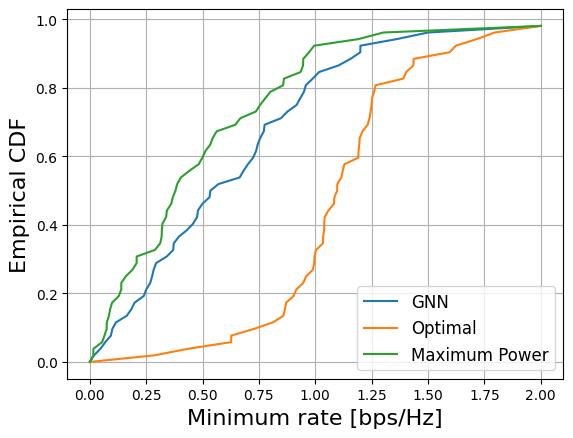

In [26]:
plt.plot(gnn_rates, y_axis, label = 'GNN')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()

# Graph Data

In [27]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

class cfGraphDataset(Dataset):
    def __init__(self, norm_losses, direct, cross, KM):
        self.norm_losses = norm_losses
        self.direct = torch.tensor(direct, dtype=torch.float32)
        self.cross = torch.tensor(cross, dtype=torch.float32)
        self.KM = KM

        self.num_samples, self.num_AP, self.num_UE = self.norm_losses.shape

        self.num_nodes = self.num_AP * self.num_UE

        # Generate the dataset (graphs and labels)
        self.graphs = [self.create_graph(idx) for idx in range(self.num_samples)]

    def create_graph(self, idx):
        H = self.norm_losses[idx]
        x = torch.tensor(H.flatten()[:,None], dtype=torch.float32)

        # Fully connected graph
        edge_index = torch.tensor([
            [i, j] for i in range(self.num_nodes) for j in range(i+1, self.num_nodes) #if i != j
            # [i, j] for i in range(self.num_nodes) for j in range(self.num_nodes) if i != j
        ], dtype=torch.long).T  # shape: [2, num_edges]

        node_indices = np.arange(self.num_nodes)
        row_indices, col_indices = np.unravel_index(node_indices, (self.num_AP, self.num_UE))
        node_feat = H[row_indices, col_indices]
        edge_attr_mtx = H[row_indices[:, None], col_indices[None, :]]
        edge_attr_mtx = torch.tensor(edge_attr_mtx, dtype=torch.float32)
        # edge_attr = edge_attr_mtx[edge_index[0], edge_index[1]][:,None]
        edge_attr = torch.cat([edge_attr_mtx[edge_index[0], edge_index[1]][:,None], edge_attr_mtx[edge_index[1], edge_index[0]][:,None]], dim=-1)

        # y = torch.tensor(self.labels[idx], dtype=torch.float32)

        data = Data(
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            direct = self.direct[idx],
            cross = self.cross[idx],
            # y=y
        )
        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.graphs[idx], self.direct[idx], self.cross[idx]

# Utils

In [28]:
import torch
import random
from collections import defaultdict

In [29]:
def star_subgraph(adjacency_matrix, subgraph_size=4):
    num_nodes = adjacency_matrix.shape[0]
    subgraph_indices = []
    uncovered_neighbors = set(range(num_nodes))  # All nodes should be covered as neighbors at least once

    leaf_counts = defaultdict(int)

    seed_nodes = list(range(num_nodes))
    random.shuffle(seed_nodes)

    for center_node in seed_nodes:
        neighbors = [i for i in range(num_nodes) if adjacency_matrix[center_node, i] != 0 and i != center_node]
        k = subgraph_size - 1

        candidates = neighbors  # Already excludes center node

        # Case 1: Not enough neighbors → take all of them
        if len(candidates) <= k:
            sampled_neighbors = candidates

        else:
            available_new = list(set(candidates) & uncovered_neighbors)

            # Case 2a: enough new nodes → sample from them
            if len(available_new) >= k:
                sampled_neighbors = random.sample(available_new, k)

            # Case 2b: not enough new nodes → take all + fill from candidates
            else:
                sampled_neighbors = available_new
                remaining_k = k - len(sampled_neighbors)
                remaining_pool = list(set(candidates) - set(sampled_neighbors))
                remaining_pool.sort(key=lambda x: leaf_counts[x])

                sampled_neighbors += remaining_pool[:remaining_k]

        # Update uncovered neighbor set
        uncovered_neighbors -= set(sampled_neighbors)
        for node in sampled_neighbors:
            leaf_counts[node] += 1

        # Add center + its sampled neighbors
        subgraph = [center_node] + sampled_neighbors
        subgraph_indices.append(subgraph)

    return subgraph_indices


In [30]:
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    total_sample = 0
    for data, direct, cross in train_loader:
        bs = data.num_graphs
        M = direct.shape[1]
        K = data.x.shape[0] // M // bs
        optimizer.zero_grad()

        output = model(data.x, data.edge_attr, data.edge_index, data.batch) # .reshape(bs, -1)
        # output = output.reshape(bs,-1)
        power = output.reshape(bs, M, K)
        power = torch.mean(power, dim=2)
        loss = rate_loss(power, direct, cross)
        loss.backward()

        total_loss += loss.item() * bs
        total_sample += bs
        optimizer.step()

    return total_loss / total_sample

def test(model, test_loader):
    model.eval()
    total_loss = 0
    total_sample = 0
    with torch.no_grad():
        for data, direct, cross in test_loader:
            bs = data.num_graphs
            M = direct.shape[1]
            K = data.x.shape[0] // M // bs
            # optimizer.zero_grad()

            output = model(data.x, data.edge_attr, data.edge_index, data.batch) # .reshape(bs, -1)
            # output = output.reshape(bs,-1)
            power = output.reshape(bs, M, K)
            power = torch.mean(power, dim=2)
            loss = rate_loss(power, direct, cross)
            # loss.backward()

            total_loss += loss.item() * bs
            total_sample += bs

    return total_loss / total_sample

# QGNN Model

## PQC

In [63]:
import torch
import torch.nn as nn
import pennylane as qml
from pennylane import numpy as np
import torch.nn.functional as F
from torch_geometric.nn import MLP, global_add_pool, global_mean_pool, global_max_pool

def message_passing_pqc(strong, twodesign, inits, wires):
    edge, center, neighbor, ancilla1, ancilla2 = wires

    qml.CRX(inits[0, 0], wires=[neighbor, ancilla1])
    qml.CRY(inits[0, 1], wires=[edge, ancilla1])
    qml.CRZ(inits[0, 2], wires=[neighbor, ancilla2])
    qml.CRY(inits[0, 3], wires=[edge, ancilla2])
    # qml.StronglyEntanglingLayers(weights=strong[0], wires=[edge, neighbor, ancilla1])
    # qml.StronglyEntanglingLayers(weights=strong[1], wires=[ancilla1, neighbor, ancilla2])


def qgcn_enhance_layer(inputs, spreadlayer, strong, twodesign, inits, update):
    edge_feat_dim = feat_dim = node_feat_dim = 2
    inputs = inputs.reshape(-1,feat_dim)

    # The number of avaible nodes and edges
    total_shape = inputs.shape[0]
    num_nodes = (total_shape+1)//2
    num_edges = num_nodes - 1

    adjacency_matrix, vertex_features = inputs[:num_edges,:], inputs[num_edges:,:]

    # The number of qubits assiged to each node and edge
    num_qbit = spreadlayer.shape[1]
    num_nodes_qbit = (num_qbit+1)//2
    num_edges_qbit = num_nodes_qbit - 1

    center_wire = num_edges_qbit


    for i in range(num_edges):
        qml.RY(adjacency_matrix[i][0], wires=i)
        qml.RZ(adjacency_matrix[i][1], wires=i)
        # qml.RX(adjacency_matrix[i][2], wires=i)

    for i in range(num_nodes):
        qml.RY(vertex_features[i][0], wires=center_wire+i)
        qml.RZ(vertex_features[i][1], wires=center_wire+i)
        # qml.RX(vertex_features[i][2], wires=center_wire+i)


    for i in range(num_edges):

        message_passing_pqc(strong=strong, twodesign=twodesign, inits=inits,
                            wires=[i, center_wire, center_wire+i+1, num_qbit, num_qbit+1])

    qml.StronglyEntanglingLayers(
        weights=update[0],
        wires=[center_wire, num_qbit, num_qbit+1]
        )
    # probs = qml.probs(wires=[center_wire, num_qbit, num_qbit+1])
    # return probs
    # expval = [qml.expval(qml.PauliZ(w)) for w in [center_wire, num_qbit, num_qbit+1]]
    expval = [
        qml.expval(qml.PauliX(center_wire))
    ]
    return expval


def small_normal_init(tensor):
    return torch.nn.init.normal_(tensor, mean=0.0, std=0.1)

def uniform_pi_init(tensor):
    return nn.init.uniform_(tensor, a=0.0, b=np.pi)

def identity_block_init(tensor):
    with torch.no_grad():
        tensor.zero_()
        if tensor.ndim < 1:
            return tensor  # scalar param

        # Total number of parameters
        total_params = tensor.numel()
        num_active = max(1, total_params // 3)

        # Flatten, randomize, and reshape
        flat = tensor.view(-1)
        active_idx = torch.randperm(flat.shape[0])[:num_active]
        flat[active_idx] = torch.randn_like(flat[active_idx]) * 0.1

        return tensor

def input_process(tensor):
    # return torch.clamp(tensor, -1.0, 1.0) * np.pi
    return torch.tanh(tensor) * np.pi


## Model

In [64]:
class QGNN(nn.Module):
    def __init__(self, q_dev, w_shapes, node_input_dim=1, edge_input_dim=1,
                 graphlet_size=4, hop_neighbor=1):
        super().__init__()
        self.hidden_dim = 128
        self.graphlet_size = graphlet_size
        self.hop_neighbor = hop_neighbor
        self.pqc_dim = 2 # number of feat per pqc for each node
        self.chunk = 1
        self.final_dim = self.pqc_dim * self.chunk # 2
        self.pqc_out = 1 # probs?


        self.qconvs = nn.ModuleDict()
        self.upds = nn.ModuleDict()
        self.aggs = nn.ModuleDict()
        self.norms = nn.ModuleDict()


        self.node_input_dim = node_input_dim
        self.edge_input_dim = edge_input_dim if edge_input_dim > 0 else 1


        self.input_node = MLP(
                    [self.node_input_dim, self.hidden_dim, self.final_dim],
                    act='leaky_relu',
                    norm=None, dropout=0.3
            )

        self.input_edge = MLP(
                    [self.edge_input_dim, self.hidden_dim, self.pqc_dim],
                    act='leaky_relu',
                    norm=None, dropout=0.3
            )

        for i in range(self.hop_neighbor):
            qnode = qml.QNode(qgcn_enhance_layer, q_dev,  interface="torch")
            self.qconvs[f"lay{i+1}"] = qml.qnn.TorchLayer(qnode, w_shapes, uniform_pi_init)

            self.upds[f"lay{i+1}"] = MLP(
                    [self.pqc_dim + self.pqc_out, self.hidden_dim, self.pqc_dim],
                    act='leaky_relu',
                    norm=None, dropout=0.3
            )

            self.norms[f"lay{i+1}"] = nn.LayerNorm(self.pqc_dim)

        self.final_layer = MLP(
                [self.final_dim, self.hidden_dim, 1],
                act='leaky_relu',
                norm=None, dropout=0.3
        )

    def forward(self, node_feat, edge_attr, edge_index, batch):
        edge_index = edge_index.t()
        num_nodes = node_feat.size(0)
        num_nodes_model = self.graphlet_size
        num_edges_model = self.graphlet_size - 1

        if edge_attr is None:
            edge_attr = torch.ones((edge_index.size(0), self.edge_input_dim), device=node_feat.device)

        edge_features = edge_attr.float()
        node_features = node_feat.float()

        edge_features = self.input_edge(edge_features)
        node_features = self.input_node(node_features)

        node_features = input_process(node_features)
        # # node_features = node_features + 0.01 * torch.randn_like(node_features)
        edge_features = input_process(edge_features)


        idx_dict = {
            (int(u), int(v)): i
            for i, (u, v) in enumerate(edge_index.tolist())
        }


        adj_mtx = torch.zeros((num_nodes, num_nodes), dtype=torch.int)
        adj_mtx[edge_index[:, 0], edge_index[:, 1]] = 1
        adj_mtx[edge_index[:, 1], edge_index[:, 0]] = 1


        for i in range(self.hop_neighbor):
            subgraphs = star_subgraph(adj_mtx.cpu().numpy(), subgraph_size=self.graphlet_size)
            node_upd = torch.zeros((num_nodes, self.final_dim), device=node_features.device)
            q_layer = self.qconvs[f"lay{i+1}"]
            upd_layer = self.upds[f"lay{i+1}"]
            norm_layer = self.norms[f"lay{i+1}"]

            # updates_node = node_features.clone()

            centers = []
            updates = []

            for sub in subgraphs:
                center, *neighbors = sub

                n_feat = node_features[sub]
                edge_idxs = [
                    idx_dict[(min(center, int(n)), max(center, int(n)))] 
                    for n in neighbors 
                ]
                e_feat    = edge_features[edge_idxs]
                inputs = torch.cat([e_feat, n_feat], dim=0)

                all_msg = q_layer(inputs.flatten())
                aggr = all_msg
                update_vec = upd_layer(torch.cat([node_features[center], aggr], dim=0))

                centers.append(center)
                updates.append(update_vec)

            centers = torch.tensor(centers, device=node_features.device)
            updates = torch.stack(updates, dim=0)
            updates_node = torch.zeros_like(node_features)
            updates_node = updates_node.index_add(0, centers, updates)

            # node_features = norm_layer(updates_node + node_features)
            node_features = updates_node + node_features
        # graph_embedding = global_mean_pool(node_features, batch)

        return torch.sigmoid(self.final_layer(node_features))

# Main

## Hyperparameters

In [76]:

training_sam = 100
testing_sam = 50
num_epochs = 10
batch_size = 16

In [77]:
## Quantum hyperparameters
graphlet_size = 4
node_qubit = graphlet_size
edge_qubit = node_qubit - 1
n_qubits = node_qubit + edge_qubit
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_dev = qml.device("default.qubit", wires=n_qubits + 2) # number of ancilla qubits

num_ent_layers = 1

In [78]:
w_shapes_dict = {
    'spreadlayer': (0, n_qubits, 1),
    'strong': (2, num_ent_layers, 3, 3), # 3
    # 'strong': (3, args.num_ent_layers, 2, 3), # 2
    'inits': (1, 4),
    'update': (1, num_ent_layers, 3, 3), # (1, args.num_ent_layers, 2, 3)
    'twodesign': (0, num_ent_layers, 1, 2)
}

## Data loader

In [79]:
data = scipy.io.loadmat('cf_train_6_30.mat')
beta_train = data['betas'][:training_sam]
direct_train = data['directs'][:training_sam]
cross_train = data['corsses'][:training_sam].transpose(0,2,1)

In [80]:
test_data = scipy.io.loadmat('cf_test_6_30.mat')
beta_test = test_data['betas'][:testing_sam]
direct_test = test_data['directs'][:testing_sam]
cross_test = test_data['corsses'][:testing_sam].transpose(0,2,1)

In [81]:
opt_rate = test_data['R_cf_opt_min'][:,:testing_sam]

In [82]:
norm_train_losses, norm_test_losses = normalize_data(beta_train**(1/2), beta_test**(1/2) )

In [83]:
## For GNNs, we allow train_K \neq test_K
train_K, train_M = beta_train.shape[2], beta_train.shape[1]
test_K, test_M = beta_test.shape[2], beta_test.shape[1]

In [84]:
norm_test_losses.shape

(50, 30, 6)

In [85]:
train_dataset = cfGraphDataset(norm_train_losses, direct_train, cross_train, (train_K, train_M))
test_dataset = cfGraphDataset(norm_test_losses, direct_test, cross_test, (test_K, test_M))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [86]:
node_input_dim = train_dataset[0][0].x.shape[1]
edge_input_dim = train_dataset[0][0].edge_attr.shape[1]
num_gnn_layers = 2

In [87]:
import torch.optim.lr_scheduler as lr_scheduler

model = QGNN(
        q_dev=q_dev,
        w_shapes=w_shapes_dict,
        node_input_dim=node_input_dim,
        edge_input_dim=edge_input_dim,
        graphlet_size=node_qubit,
        hop_neighbor=num_gnn_layers,
        # num_classes=num_classes,
        # one_hot=0
    )

optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)


In [88]:
training_sinr = []
testing_sinr = []
for epoch in range(num_epochs):
    # Train the model
    avg_train_loss = train(model, train_loader, optimizer)
    scheduler.step()
    avg_test_sinr = test(model, test_loader)
    training_sinr.append(avg_train_loss)
    testing_sinr.append(avg_test_sinr)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training loss: {-avg_train_loss:.4f}, Training SINR: {training_sinr[-1]:.4f}, Testing SINR: {testing_sinr[-1]:.4f}")

Epoch 1/10, Training loss: 0.5842, Training SINR: -0.5842, Testing SINR: -0.4571
Epoch 2/10, Training loss: 0.5880, Training SINR: -0.5880, Testing SINR: -0.4571
Epoch 3/10, Training loss: 0.5880, Training SINR: -0.5880, Testing SINR: -0.4571
Epoch 4/10, Training loss: 0.5880, Training SINR: -0.5880, Testing SINR: -0.4571


KeyboardInterrupt: 

In [ ]:
eval_loader = DataLoader(test_dataset, batch_size=testing_sam, shuffle=False)

for data, direct, cross in eval_loader:
    bs = data.num_graphs
    M = direct.shape[1]
    K = data.x.shape[0] // M // bs
    optimizer.zero_grad()

    output = model(data.x, data.edge_attr, data.edge_index, data.batch) # .reshape(bs, -1)
    # output = output.reshape(bs,-1)
    power = output.reshape(bs, M, K)
    power = torch.mean(power, dim=2)
    qgnn_rates = rate_loss(power, direct, cross, True).flatten().detach().numpy()

    full = torch.ones_like(power)
    all_one_rates = rate_loss(full, direct, cross, True).flatten().numpy()
    
test_data = scipy.io.loadmat('cf_test_6_30.mat')
opt_rates = test_data['R_cf_opt_min'][:,:testing_sam]

In [ ]:
num_ep = test_layouts
min_rate, max_rate = 0, 2
y_axis = np.arange(0, 1.0, 1/(num_ep+2))
qgnn_rates.sort(); all_one_rates.sort(); opt_rates.sort()
qgnn_rates = np.insert(qgnn_rates, 0, min_rate); qgnn_rates = np.insert(qgnn_rates,num_ep+1,max_rate)
all_one_rates = np.insert(all_one_rates, 0, min_rate); all_one_rates = np.insert(all_one_rates,num_ep+1,max_rate)
opt_rates = np.insert(opt_rates, 0, min_rate); opt_rates = np.insert(opt_rates,num_ep+1,max_rate)

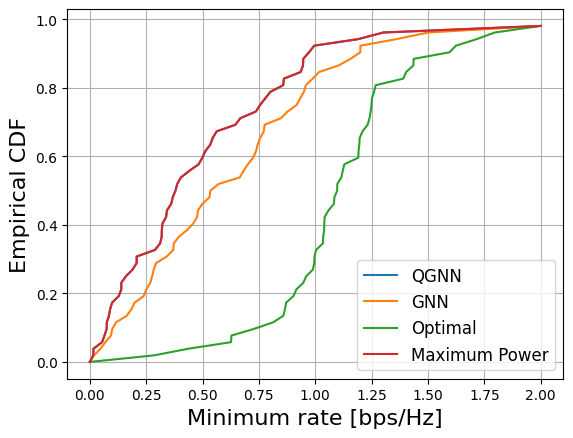

In [ ]:
plt.plot(qgnn_rates, y_axis, label = 'QGNN')
plt.plot(gnn_rates, y_axis, label = 'GNN')
plt.plot(opt_rates, y_axis, label = 'Optimal')
plt.plot(all_one_rates, y_axis, label = 'Maximum Power')
plt.xlabel('Minimum rate [bps/Hz]', {'fontsize':16})
plt.ylabel('Empirical CDF', {'fontsize':16})
plt.legend(fontsize = 12)
plt.grid()